In [1]:
# Calculating the field in a levitator using the matrix method discussed in 
# Andrade et al. ''Matrix method for acoustic levitation simulation''
# May help for optimizing parameters in our levitator,
#  especially curvature radius of the reflector 

## _v2: calculate using lists of points instead of meshgrids for more flexible geometries

import numpy as np
import pylab as plt
import numpy.ma as ma
from mpl_toolkits import mplot3d
from time import time

Transfer matrix calculated in: 0.10279059410095215 s
Transfer matrix calculated in: 0.12452077865600586 s
Transfer matrix calculated in: 0.08763647079467773 s
Transfer matrix calculated in: 0.08087944984436035 s
Term 1: 0.007106304168701172 s
Term 2: 0.015086174011230469 s
Term 3: 0.06608986854553223 s
Term 4: 0.17372369766235352 s
Term 5: 0.17899250984191895 s
(5, 4071)
(5, 4071)


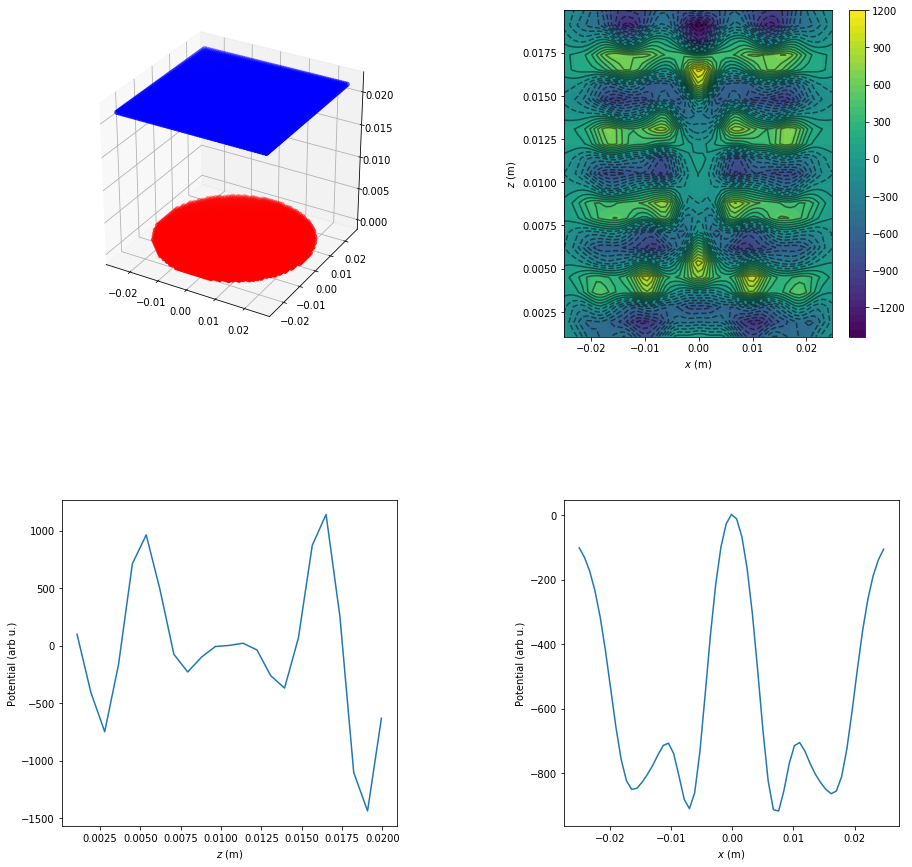

In [ ]:
# Constants
freq = 40000
omega = 2*np.pi*freq
c = 343
wavel = c/freq
k = 2 * np.pi/wavel
rho = 1 
a = 10**(-3)

# Initialize the list of points representing the transducer
def grid_circle(R,d,x0,y0,z0):
    x_points = np.arange(-R,R,d)+x0
    y_points = np.arange(-R,R,d)+y0
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    indx = np.where((positions[0,:]-x0)**2+(positions[1,:]-y0)**2<R**2)[0]
    positions = positions[:,indx]
    return positions

# Planar reflector
def grid_rectangle(Rx,Ry,d,z0):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    return positions

# Planar reflector w/ phase ramp
def rectangle_phaseramp(Rx,Ry,d,z0,m,delta,phs):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    phi = np.arctan2(positions[1,:],positions[0,:])
    positions[2,:] -= delta*np.cos(m*phi+phs)
    return positions

# Planar reflector with tilt
def grid_tilt(Rx,Ry,d,z0,theta):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    positions[2,:]+= positions[0,:]*np.tan(theta)
    return positions

# Spherical reflector
def grid_spherical(R,d,z0,Rc):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    positions[2,:]+= np.sqrt(Rc**2-positions[0,:]**2-positions[1,:]**2)-Rc+z0
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    return positions

# Planar reflector with small hole
def grid_planar_hole(R,d,z0,Rh):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    indx = np.where(positions[0,:]**2+positions[1,:]**2>Rh**2)[0]
    positions = positions[:,indx]
    return positions

# Conical reflector
def grid_conical(R,d,z0,alpha):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    positions[2,:] += (R-r)/np.tan(alpha)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    return positions

# Conical reflector with azimuthal phase ramp
def conical_phaseramp(R,d,z0,alpha,m,delta,phs):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    positions[2,:] += (R-r)/np.tan(alpha)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    phi = np.arctan2(positions[1,:],positions[0,:])
    positions[2,:] -= delta*np.cos(m*phi+phs)
    return positions

# # Target points (internal volume)
# def field_points_old(Rx,Ry,Rz,d,x0,y0,z0):
#     x_points = np.arange(-Rx,Rx,d) + x0
#     y_points = np.arange(-Ry,Ry,d) + y0
#     z_points = np.arange(-Rz,Rz,d) + z0
#     g= np.meshgrid(x_points,y_points,z_points)
#     print(np.shape(g))
#     positions = np.vstack(list(map(np.ravel,g)))
#     return positions, g

# Function options for mid-plane xy and xz slices
def field_points(Rx,Ry,Rz,d,x0,y0,z0, plane=None):
    if plane == None:
        x_points = np.arange(-Rx,Rx,d) + x0
        y_points = np.arange(-Ry,Ry,d) + y0
        z_points = np.arange(-Rz,Rz,d) + z0
        g= np.meshgrid(x_points,y_points,z_points)
        positions = np.vstack(list(map(np.ravel,g)))
    if plane == 'xy':
        x_points = np.arange(-Rx,Rx,d) + x0
        y_points = np.arange(-Ry,Ry,d) + y0
        z_points = np.asarray([-d,0,d]) + z0
        g= np.meshgrid(x_points,y_points,z_points)
        positions = np.vstack(list(map(np.ravel,g)))
    if plane == 'xz':
        x_points = np.arange(-Rx,Rx,d) + x0
        y_points = np.asarray([-d,0,d]) + y0
        z_points = np.arange(-Rz,Rz,d) + z0
        g= np.meshgrid(x_points,y_points,z_points)
        positions = np.vstack(list(map(np.ravel,g)))
    else:
        print('Enter xy, xz, or None for plane arg')
    return positions, g

def transfer(source,target):
    t = time()
    dx = target[0,:,None] - source[0,None,:]
    dy = target[1,:,None] - source[1,None,:]
    dz = target[2,:,None] - source[2,None,:]
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    source_area = d_t**2 # area represented per gridpoint, currently only accurate for constant z surfaces
    print('Transfer matrix calculated in: {} s'.format(time()-t))
    return source_area * (np.exp(-1j*k*r))/r

def transducer_output(points, amplitude, phase):
    output = np.ones(np.shape(points[0,:]),dtype='complex') * amplitude * np.exp(1j*phase)
    return output

# Serves as a dictionary for the terms in the expansion
def calculate_term(num):
    opt = 'optimal'
    t = time()
    pref = 1j/wavel
    if num ==1:
        term = np.einsum('mt,t',TTM, U , optimize=opt)
    if num ==2:
        term = pref * np.einsum('mr,rt,t',TRM,TTR,U, optimize=opt)
    if num ==3:
        term = pref**2 * np.einsum('mt,tr,rt,t' ,TTM,TRT,TTR,U, optimize=opt)
    if num ==4:
        term = pref**3 * np.einsum('mr,rt,tr,rt,t',TRM,TTR,TRT,TTR,U, optimize=opt)
    if num ==5: 
        term = pref**4 * np.einsum('mt,tr,rt,tr,rt,t',TTM,TRT,TTR,TRT,TTR,U, optimize=opt)
    print('Term {}: {} s'.format(num,time()-t))
    return term


# Calculate potential field at level of accuracy given by num_terms
def calculate_fields(num_terms):
    pref1 = omega*rho*c/wavel
    terms = []
    for i in range(num_terms):
        terms.append(calculate_term(i+1)) #count terms starting at 1 rather than 0
    terms = np.vstack(terms)
    print(np.shape(terms))
    print(np.shape(np.asarray(terms)))   
    pressure = pref1*np.sum(terms,axis=0)
    pressure_grid = np.reshape(pressure, np.shape(field_grid[0]))

    velocity = np.gradient(-pressure_grid/(1j*omega*rho), d_f)
    pressure_squared = pressure*np.conjugate(pressure)

    velocity_squared = np.einsum('aijk,aijk->ijk',velocity,np.conjugate(velocity))
    velocity_squared = np.ravel(velocity_squared)
    potential = np.real( 2*np.pi*a**3 *(pressure_squared/(3*rho*c**2) - rho*velocity_squared/2) )
    potential_grid = np.reshape(potential,np.shape(field_grid[0]))
    force_grid = np.gradient(-potential_grid, d_f)
    return potential_grid

## Inputs 
d_t = wavel/10 # grid spacing for (t)ransducer, (r)eflector, (f)ield
d_r = wavel/10
d_f = wavel/10
R_t = 2.5*10**(-2)# our transducer is 2.5 cm radius
R_r = R_t
R_f = R_t
H = wavel*(5/2) # z position of reflector
x0_t, y0_t, z0_t = [0,0,0] # transducer center

transducer = grid_circle(R_t,d_t,x0_t,y0_t,z0_t)
reflector = grid_rectangle(R_r,R_r,d_r,H)
# reflector = grid_tilt(R_r,R_r,d_r,H,(10/180)*np.pi)
#reflector = grid_spherical(R_r,d_r,H,wavel*5)
#reflector = grid_planar_hole(R_r,d_r,H,wavel/2)
#reflector = grid_conical(R_r,d_r,H,(70/180)*np.pi)
#reflector = conical_phaseramp(R_r,d_r,H,(75/180)*np.pi,2,R_r*.1,(0/180)*np.pi)
#reflector = rectangle_phaseramp(R_r,R_r,d_r,H,1,R_r*.1,0)

# start sampling just above transducer to avoid diverging pressure at transducer face
field, field_grid = field_points(R_f, d_f+.01 ,H/2*.9,d_f,0,0,H/2 , plane='xz') 

U = transducer_output(transducer, 1, 0)
TTM = transfer(transducer,field) # Transfer Transducer (to) Measurement points (field)
TRM = transfer(reflector,field) # Reflector to Measurement points
TTR = transfer(transducer,reflector) # Transducer to Reflector
TRT = transfer(reflector,transducer) # Reflector to Transducer

potential_grid = calculate_fields(5)


## Plotting
midX = int(len(field_grid[0][0,:,0])/2)
midY = int(len(field_grid[0][:,0,0])/2)
midZ = int(len(field_grid[0][0,0,:])/2)

time_tag = str(int(time()))
imgformat = '.png'
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
ax[0,0].remove()
ax3d = fig.add_subplot(2,2,1, projection='3d')
ax3d.scatter(transducer[0,:], transducer[1,:],transducer[2,:],color='r')
ax3d.scatter(reflector[0,:], reflector[1,:],reflector[2,:],color='blue')

cpl = ax[0,1].contourf(field_grid[0][0,:,0],field_grid[2][0,0,:],potential_grid[midY,:,:].transpose(),levels=50)
fig.colorbar(cpl,ax=ax[0,1])
ax[0,1].contour(field_grid[0][0,:,0],field_grid[2][0,0,:],potential_grid[midY,:,:].transpose(),levels=25, zorder=3,colors='black',alpha=0.5)
ax[0,1].set_xlabel(r'$x$ (m)')
ax[0,1].set_ylabel(r'$z$ (m)')

# fig2 = plt.figure()
# ax2 = fig2.add_subplot(projection='3d')
# ax2.scatter(transducer[0,:], transducer[1,:],transducer[2,:],color='r')
# ax2.scatter(reflector[0,:], reflector[1,:],reflector[2,:],color='blue',zorder=4)
# ax2.scatter(field[0,:], field[1,:],field[2,:],c=np.ravel(phase),alpha=.25,cmap='hsv')
# fig2.savefig('images/'+time_tag + 'phase3D'+imgformat)

ax[1,0].plot(field_grid[2][0,0,:],potential_grid[midY,midX,:])
# ax[1,0].plot(field_grid[2][0,0,:],potential_grid[midY-1,midX-1,:])
# ax[1,0].plot(field_grid[2][0,0,:],potential_grid[midY+1,midX+1,:])
ax[1,0].set_xlabel(r'$z$ (m)')
ax[1,0].set_ylabel('Potential (arb u.)')
ax[1,1].plot(field_grid[0][0,:,0],potential_grid[midY,:,midZ])
# ax[1,1].plot(field_grid[0][0,:,0],potential_grid[midY-1,:,midZ-1])
# ax[1,1].plot(field_grid[0][0,:,0],potential_grid[midY+1,:,midZ+1])
ax[1,1].set_xlabel(r'$x$ (m)')
ax[1,1].set_ylabel('Potential (arb u.)')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

plt.show()
save = input("Save figure? (enter file name if yes, return if no)")
if save != '':
    fileName = 'images/{}{}'.format(save,imgformat)
    fig.savefig(fileName)
    print("Figure saved to {}".format(fileName))